### Simulate LP Activity using GBM
* https://medium.com/@chiqing/uniswap-v2-explained-beginner-friendly-b5d2cb64fe0f

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.cpt import SolveDeltas
from python.dev.math.model import BrownianModel
from python.dev.cpt import Liquidity
from python.dev.cpt import LiquidityPoolUSD
from python.dev.math.model import EventSelectionModel
from python.dev.math.model import TokenDeltaModel

In [2]:
from python.dev.simulation import SimulateLiquidity
from python.dev.simulation import SimLPFees

**Simulate prices**

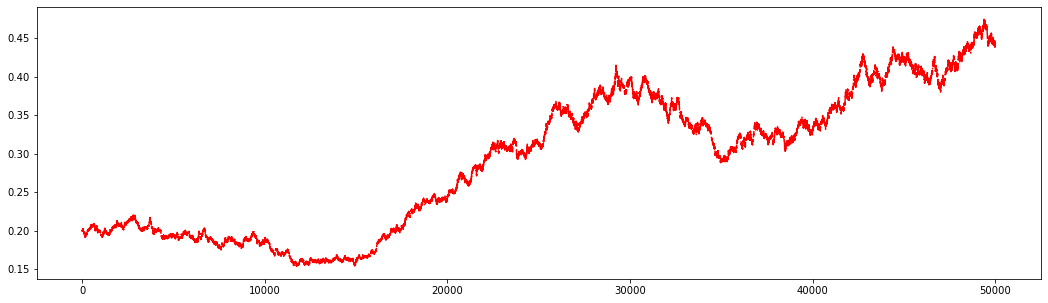

In [3]:
n_runs = 50000
start_price = 0.2
mu = 0.4
sigma = 0.5

b = BrownianModel(start_price)
p_arr = b.gen_gbm(mu, sigma, n_runs)

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 

**Calculate LP holdings using simulated prices**

In [4]:
tdel = TokenDeltaModel(10000) 
liq = Liquidity(100000, 20000, 'SYS','DIA')
simLiq = SimulateLiquidity(liq, tdel)
simLiq.run(p_arr, lp_rate = 0.55)

usd_arr  = simLiq.get_usd_arr()

simLiq.check(p_arr, 10000)

raw: 0.1876915 y/x: 0.1878047 dy/dx: 0.1889708 liq: 1070310.2305278


**Determine valuations from LP position**

In [5]:
start_pt = 0
init_pos_sys = 10000
init_pos_dai = p_arr[start_pt]*init_pos_sys

sys_arr = simLiq.get_x_arr()
dai_arr = simLiq.get_y_arr()

lpVal = LiquidityPoolUSD(sys_arr, dai_arr, p_arr)
hodl_usd = lpVal.hodl_position_usd(init_pos_sys, init_pos_dai, start_pt)
lp_pos = lpVal.lp_position_usd(init_pos_sys, init_pos_dai, start_pt)

print('Original position: {:.0f} SYS / {:.0f} DIA'.format(init_pos_sys, init_pos_dai))

Original position: 10000 SYS / 2000 DIA


**Determine collected fees from LP position**

In [6]:
simFees = SimLPFees(simLiq, lpVal)
lp_pos_fees = simFees.lp_position_fees_usd(init_pos_sys, init_pos_dai, start_pt)
percent_returns = simFees.position_percent_returns(init_pos_sys, init_pos_dai, start_pt)

print('percent returns: {:.3f}%'.format(100*percent_returns[-1]))
print('collected fees:  ${:.2f}'.format(lp_pos_fees[-1]))

percent returns: 12.452%
collected fees:  $498.06


**Plots**

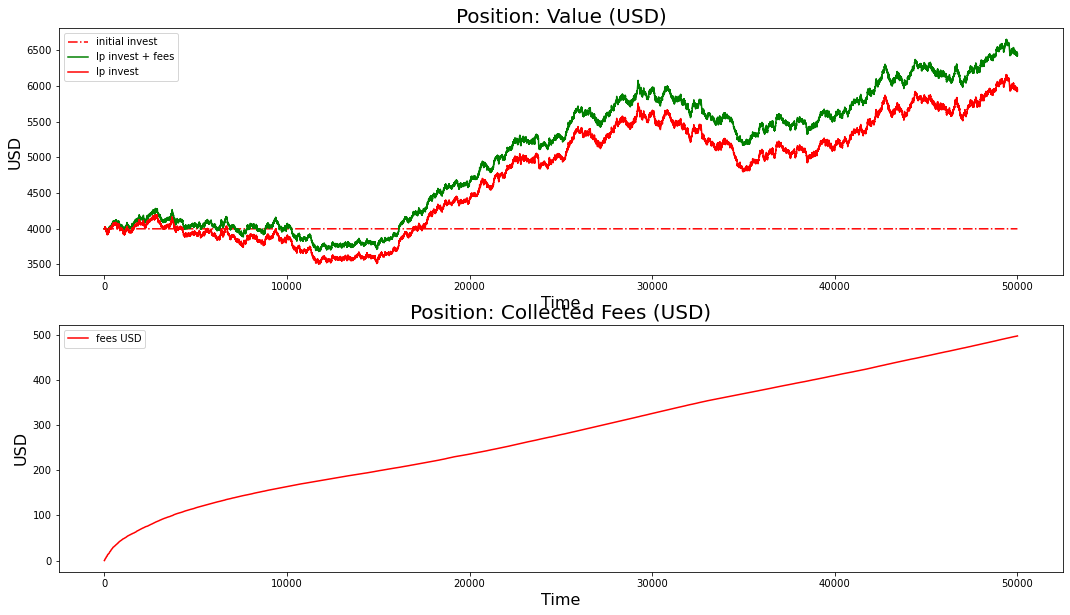

In [7]:
initial_usd = 2*p_arr[0]*init_pos_sys

x_val = np.arange(0,len(p_arr))
fig, (USD_ax, fee_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(18, 10))
USD_ax.plot(x_val, np.repeat(initial_usd, len(p_arr)), color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(x_val[1:], lp_pos[1:] + lp_pos_fees, color = 'g',label='lp invest + fees') 
USD_ax.plot(x_val[1:], lp_pos[1:], color = 'r',label='lp invest') 
USD_ax.set_title("Position: Value (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)
USD_ax.legend()

fee_ax.plot(x_val[1:], lp_pos_fees, color = 'r',label='fees USD') 
fee_ax.set_title("Position: Collected Fees (USD)", fontsize=20)
fee_ax.set_ylabel("USD", fontsize=16)
fee_ax.set_xlabel('Time', fontsize=16)
fee_ax.legend()


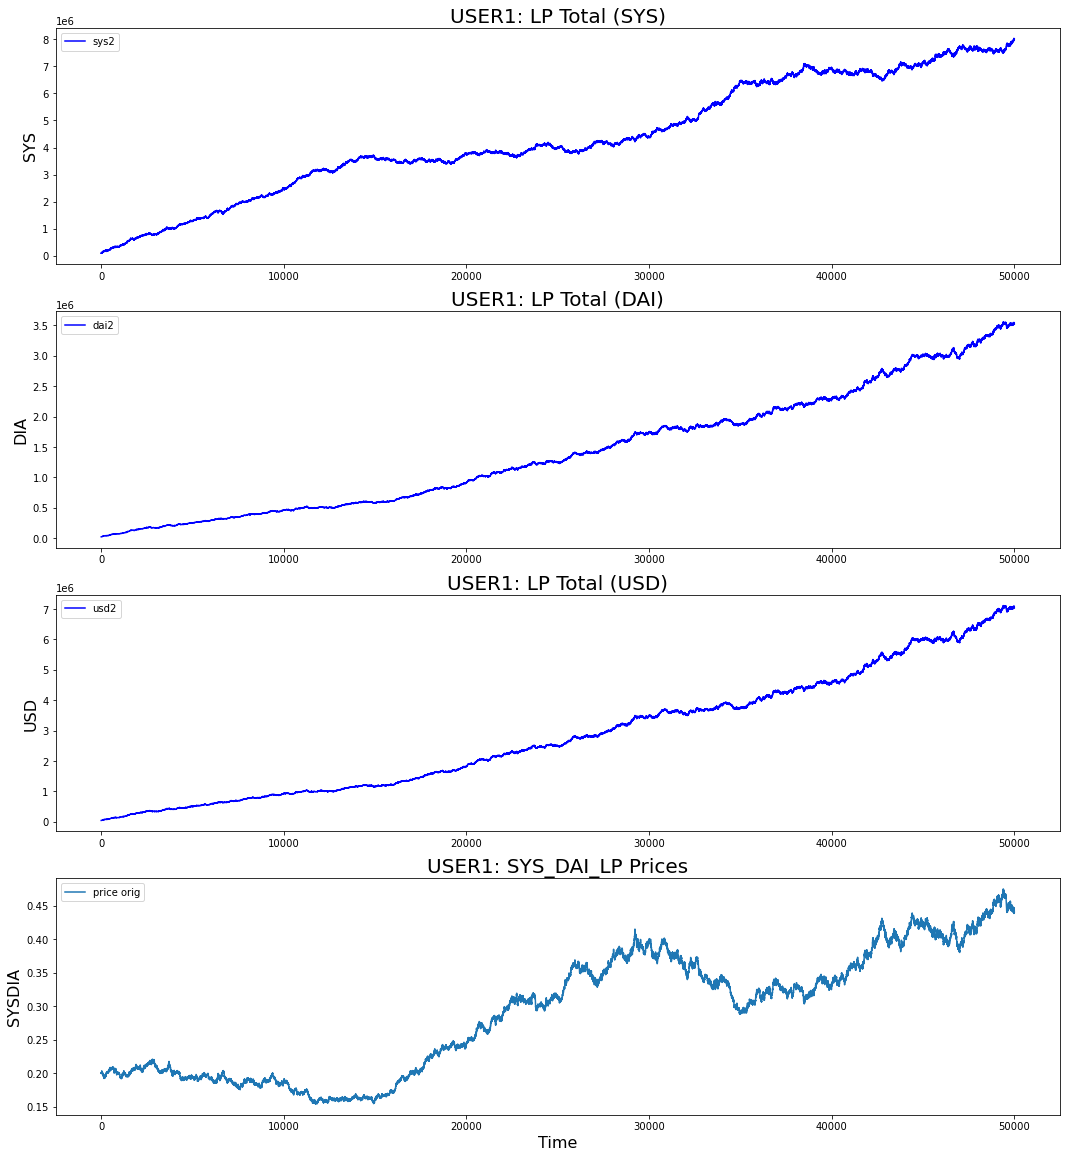

In [8]:
fig, (SYS_ax, DAI_ax, USD_ax, price_ax) = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=(18, 20))
SYS_ax.plot(sys_arr, color = 'b',label='sys2') 
SYS_ax.set_title("USER1: LP Total (SYS)", fontsize=20)
SYS_ax.set_ylabel("SYS", fontsize=16)
SYS_ax.legend()

DAI_ax.plot(dai_arr, color = 'b',label='dai2') 
DAI_ax.set_title("USER1: LP Total (DAI)", fontsize=20)
DAI_ax.set_ylabel("DIA", fontsize=16)
DAI_ax.legend()

USD_ax.plot(usd_arr, color = 'b',label='usd2') 
USD_ax.set_title("USER1: LP Total (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.legend()

price_ax.plot(p_arr, label='price orig') 
price_ax.set_title("USER1: SYS_DAI_LP Prices", fontsize=20)
price_ax.set_ylabel("SYSDIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
price_ax.legend()